# Sybil Detection

In [1]:
import os
import pandas as pd
import numpy as np

from avd.graph_learning_controller import GraphLearningController
from avd.learners.sklearner import SkLearner
from avd.configs import config
from avd.datasets.twitter import load_data

Specify output directory for classifiers.

In [2]:
output_folder = os.getcwd() + "/data/output"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Define what is considered positive and negative labels.

In [3]:
labels = {"neg": "Real", "pos": "Fake"}

We first load the Twitter graph.
load_data will return a graph object(twitter_graph) and a config object(twitter_config).

In [4]:
twitter_graph, twitter_config = load_data(labels_map=labels)
print(len(twitter_graph.vertices))

Loading labels...
Loading graph...
Data loaded.
2357960


Some of the extracted feature can be useful for understanding the result, but they will not be used in the classification proccess.

In [5]:
if twitter_graph.is_directed:
    meta_data_cols = ["dst", "src", "out_degree_v", "in_degree_v", "out_degree_u", "in_degree_u"]
else:
    meta_data_cols = ["dst", "src", "number_of_friends_u", "number_of_friends_v"]

Finally, we train the classification algorithm.
The Twitter dataset is incomplete and missing a lot of data.
In order to deal with this problem, we train 10 times and aggregate the results.

In [6]:
#for i in range(10):
twitter_config._name = "twitter_"# + str(i) + "_"
learner = SkLearner(labels=labels)
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path, 
                      test_size={"neg": 10000, "pos": 1000},
                      train_size={"neg": 20000, "pos": 20000}, 
                      meta_data_cols=meta_data_cols)

Setting training and test sets


  3%|▎         | 307/11000 [00:00<00:03, 3067.36feature/s]

Graph loaded


114761feature [00:18, 6049.52feature/s]                     
  0%|          | 103/40000 [00:00<00:39, 1019.93feature/s]

Features were written to: /home/vsawal/cs221/fall2019/proj/Network-Anomaly-Detection/data/temp/twitter__test.csv
Graph loaded


100%|██████████| 40000/40000 [00:19<00:00, 2054.24feature/s] 


Features were written to: /home/vsawal/cs221/fall2019/proj/Network-Anomaly-Detection/data/temp/twitter__train.csv
Training 10-fold validation: {'auc': 0.7522788250000001, 'recall': 0.96905, 'precision': 0.6415741532367399, 'accuracy': 0.713775, 'fpr': 0.5415, 'tnr': 0.4585}


{'auc': 1.0,
 'recall': 0.125,
 'precision': 0.2412280701754386,
 'accuracy': 0.8456858407079646,
 'fpr': 0.05447103274559194,
 'F1': 0.16467065868263475}

In [7]:
def aggreagate_res(data_folder, res_path):
    results_frame = pd.DataFrame()
    for f in os.listdir(data_folder):
        temp_df = pd.read_csv(data_folder + "/" + f,index_col=0, encoding='utf-8', engine='python')
        results_frame = results_frame.append(temp_df)
    results_frame = results_frame.groupby("src_id").mean()

    return results_frame.reset_index()

In [8]:
df = aggreagate_res(output_folder, "res.csv").sort_values("mean_link_label", ascending=False)

In order to calculate precision at k, we add two additional columns:
1. The sum of the positive examples.
2. k  the total number of resutls until the specific row. (row number)

In [9]:
df["actual_sum"] = df["actual"].cumsum()
df["k"] = 1
df["k"] = df["k"].cumsum()

In [10]:
df.head(10)

,src_id,neg probability,edge number,pos probability,mean_link_label,sum_link_label,predicted_label,actual,actual_sum,k
3595,2104351,0.008462,13,0.991538,1.000000,13,1,1,1,1
3282,955631,0.063630,18,0.936370,0.944444,17,1,0,1,2
2289,352725,0.305262,13,0.694738,0.923077,12,1,1,2,3
62,5594,0.188146,14,0.811854,0.857143,12,1,0,2,4
3564,1886070,0.242308,13,0.757692,0.846154,11,1,0,2,5
293,17643,0.202576,16,0.797424,0.812500,13,1,0,2,6
3488,1455795,0.242708,24,0.757292,0.791667,19,1,1,3,7
774,51142,0.507262,56,0.492738,0.785714,44,0,0,3,8
1769,215410,0.406472,12,0.593528,0.750000,9,1,1,4,9
1956,262232,0.250000,19,0.750000,0.736842,14,1,1,5,10


We add an additional column that stores the p@k values by calculating the precision at k.

In [11]:
df["p@k"] = df.apply(lambda x: x["actual_sum"]/x["k"], axis=1)

In [12]:
df[["k", "p@k"]].head(10)

,k,p@k
3595,1,1.000000
3282,2,0.500000
2289,3,0.666667
62,4,0.500000
3564,5,0.400000
293,6,0.333333
3488,7,0.428571
774,8,0.375000
1769,9,0.444444
1956,10,0.500000


We can see in the p@k plot that the resuts are musch better then random which about 6%.

<Figure size 432x288 with 0 Axes>

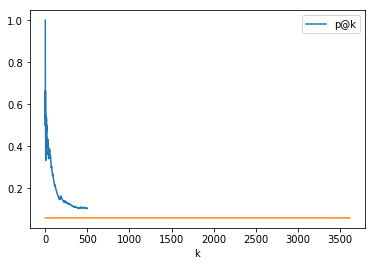

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
df[["k", "p@k"]][:500].plot(x="k", y= "p@k")
plt.plot(df[["k"]].values, np.full((len(df[["k"]]),1), 0.06))